In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [6]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /private/var/folders/5s/w3n361c16n9gbsp3rdzb9_6m0000gn/T/pip-req-build-03mfopih
  Running command git clone -q https://github.com/tensorflow/docs /private/var/folders/5s/w3n361c16n9gbsp3rdzb9_6m0000gn/T/pip-req-build-03mfopih
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.09727d0fbd24b31942ca26f21ba4045326c318baa_-py3-none-any.whl size=138299 sha256=501c031b40d3ff31ede67e690e14d42fd6526e1e0d10db8a6feae34ac4f55134
  Stored in directory: /private/var/folders/5s/w3n361c16n9gbsp3rdzb9_6m0000gn/T/pip-ephem-wheel-cache-x3l8arm1/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [7]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Get the data
First download the dataset.

In [8]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [26]:
dataset_path

'/Users/hongloc/.keras/datasets/auto-mpg.data'

### Import it using pandas

In [10]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Clean the data
The dataset contains a few unknown values.

In [28]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Europe          0
Japan           0
USA             0
dtype: int64

#### To keep this initial tutorial simple drop those rows.

In [13]:
dataset = dataset.dropna()

#### The "Origin" column is really categorical, not numeric. So convert that to a one-hot:

In [14]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [15]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data into train and test
Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [16]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

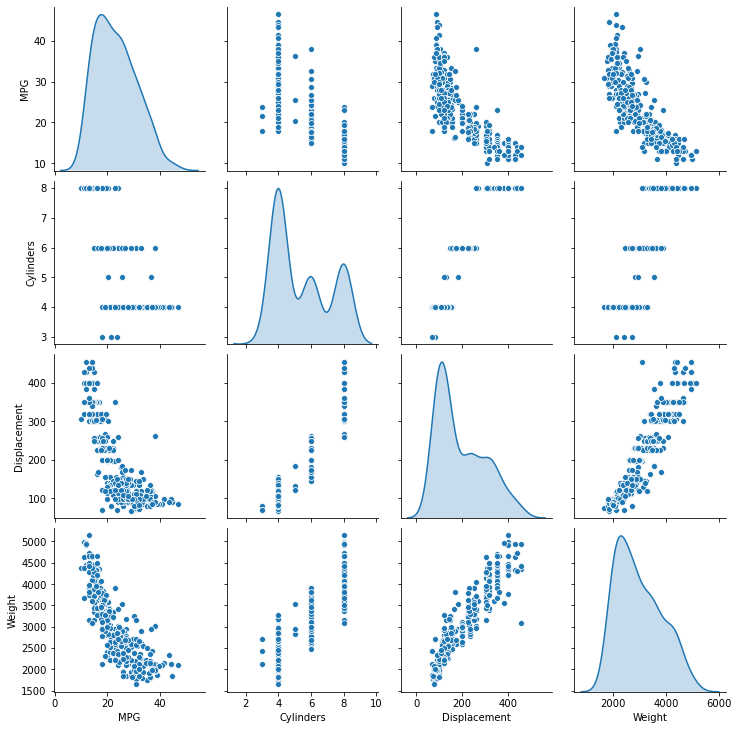

In [17]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [18]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels
Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [19]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## Normalize the data
Look again at the train_stats block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

In [20]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# The model
Build the model
Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [21]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [22]:
model = build_model()

## Inspect the model
Use the .summary method to print a simple description of the model

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of 10 examples from the training data and call model.predict on it.

In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.11135891],
       [ 0.08121252],
       [-0.3417172 ],
       [-0.05015992],
       [-0.2457554 ],
       [ 0.02724598],
       [-0.33646193],
       [ 0.05468887],
       [ 0.01327132],
       [-0.62856936]], dtype=float32)

#### It seems to be working, and it produces a result of the expected shape and type.

## Train the model
Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [25]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:574.6790,  mae:22.7344,  mse:574.6790,  val_loss:564.6464,  val_mae:22.5131,  val_mse:564.6464,  
....................................................................................................
Epoch: 100, loss:5.8136,  mae:1.6794,  mse:5.8136,  val_loss:8.1276,  val_mae:2.2370,  val_mse:8.1276,  
....................................................................................................
Epoch: 200, loss:5.0776,  mae:1.5124,  mse:5.0776,  val_loss:7.8248,  val_mae:2.1118,  val_mse:7.8248,  
....................................................................................................
Epoch: 300, loss:4.5348,  mae:1.4473,  mse:4.5348,  val_loss:8.0653,  val_mae:2.1748,  val_mse:8.0653,  
....................................................................................................
Epoch: 400, loss:4.2122,  mae:1.3875,  mse:4.2122,  val_loss:8.4997,  val_mae:2.2181,  val_mse:8.4997,  
..............................................................

#### Visualize the model's training progress using the stats stored in the history object.

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.077230,0.917077,2.077230,10.145794,2.479736,10.145794,995
996,2.072596,0.896644,2.072596,8.934063,2.216697,8.934063,996
997,2.530146,1.066505,2.530146,10.273390,2.453755,10.273390,997
998,2.028324,0.902003,2.028324,9.720848,2.390594,9.720848,998
999,2.139154,0.930643,2.139154,8.766740,2.215330,8.766740,999


In [32]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

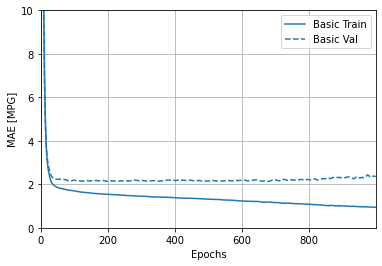

In [33]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

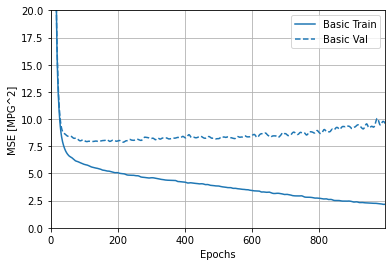

In [34]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback here.

In [35]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:555.0780,  mae:22.2789,  mse:555.0780,  val_loss:541.8599,  val_mae:21.9075,  val_mse:541.8599,  
....................................................................................................
Epoch: 100, loss:6.2859,  mae:1.7352,  mse:6.2859,  val_loss:8.7149,  val_mae:2.3033,  val_mse:8.7149,  
...

Text(0, 0.5, 'MAE [MPG]')

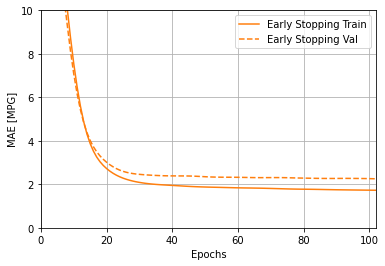

In [36]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [37]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.1671 - mae: 1.9812 - mse: 6.1671
Testing set Mean Abs Error:  1.98 MPG


# Make predictions
Finally, predict MPG values using data in the testing set:

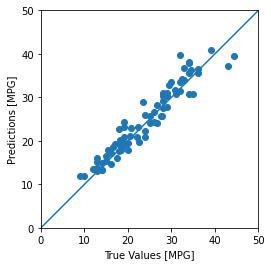

In [38]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

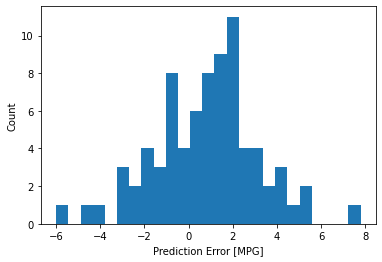

In [39]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

# Conclusion
This notebook introduced a few techniques to handle a regression problem.

1. Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
2. Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
3. When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
4. If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
5. Early stopping is a useful technique to prevent overfitting.